In [1]:
# Imports
import numpy as np
import pandas as pd
import nibabel as nib
import os
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import pearsonr
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt

In [2]:
# GPU Memory Limit
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

In [3]:
# Paths
data_path = "D:/mp/brain age/IXI-T1"
xls_path = "D:/mp/brain age/IXI.xls"
nii_files = [f for f in os.listdir(data_path) if f.endswith(".nii")]
df = pd.read_excel(xls_path)


In [4]:
df

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaT,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824
...,...,...,...,...,...,...,...,...,...,...,...,...
614,652,1,163,80,1,1,1,5,1963-12-05,1,2006-12-01,42.989733
615,653,1,172,100,1,3,1,5,1960-09-14,1,2006-12-04,46.220397
616,655,1,165,72,1,1,1,1,1941-11-23,0,NaT,NaN
617,660,1,192,85,1,2,1,4,1941-04-12,0,NaT,NaN


Shape of image: (256, 256, 150)
Data type: float64


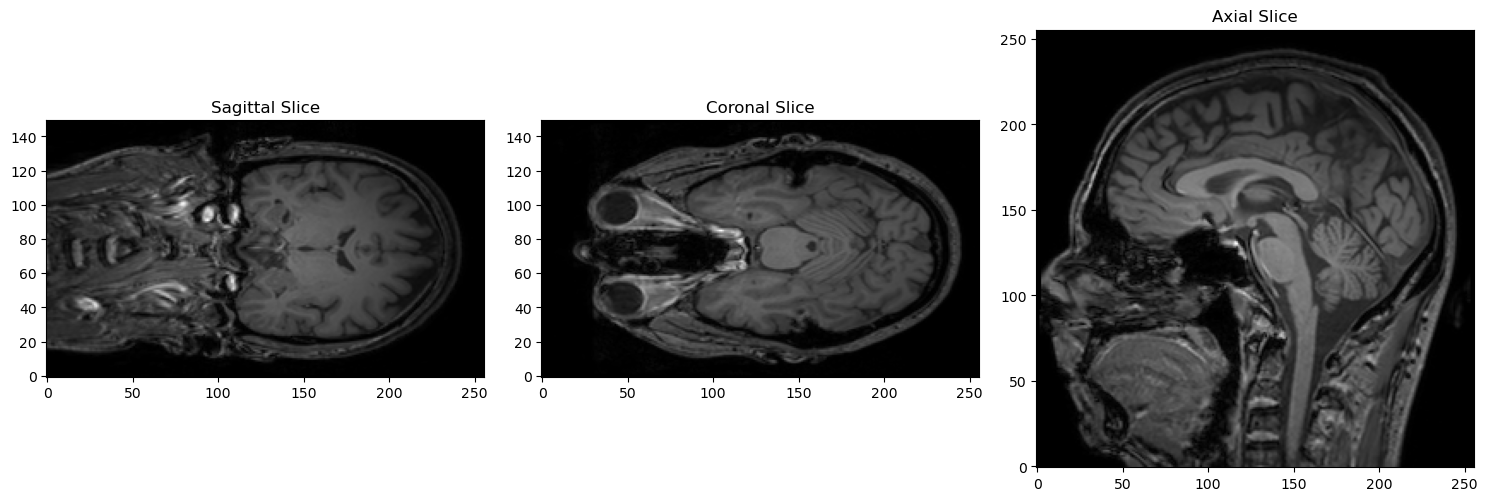

In [5]:
# Replace this with your file path
file_path = "D:/mp/brain age/IXI-T1/IXI013-HH-1212-IXIMADisoTFE12_-s3T111_-0301-00003-000001-01.nii"

# Load the NIfTI file
nii_img = nib.load(file_path)
nii_data = nii_img.get_fdata()

# Print basic info
print(f"Shape of image: {nii_data.shape}")
print(f"Data type: {nii_data.dtype}")

# Visualize a few slices from the middle
sagittal_slice = nii_data[nii_data.shape[0] // 2, :, :]
coronal_slice = nii_data[:, nii_data.shape[1] // 2, :]
axial_slice = nii_data[:, :, nii_data.shape[2] // 2]

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sagittal_slice.T, cmap="gray", origin="lower")
axes[0].set_title("Sagittal Slice")

axes[1].imshow(coronal_slice.T, cmap="gray", origin="lower")
axes[1].set_title("Coronal Slice")

axes[2].imshow(axial_slice.T, cmap="gray", origin="lower")
axes[2].set_title("Axial Slice")

plt.tight_layout()
plt.show()

In [6]:
# Helper functions
def extract_subject_id(filename):
    match = re.search(r'IXI(\d{3})', filename)
    return int(match.group(1)) if match else None

In [7]:
# def preprocess_mri_96(mri):
#     mri = resize(mri, (96, 96, 96), anti_aliasing=True).astype(np.float16)
#     mri = np.clip(mri, 0, 1068)
#     mri = (mri - 105.88) / 165.35
#     return mri

In [8]:
def preprocess_mri_128(mri):
    # Resize MRI to 128×128×128
    mri = resize(mri, (128, 128, 128), anti_aliasing=True).astype(np.float16)

    # Clip intensity values to match original scaling range
    mri = np.clip(mri, 0, 1068)

    # Normalize based on original stats (mean and std from full dataset)
    mri = (mri - 105.88) / 165.35

    return mri

In [9]:
# Map IXI ID to files
file_subject_map = {extract_subject_id(f): f for f in nii_files if extract_subject_id(f) is not None}
df['IXI_ID'] = df['IXI_ID'].astype(int)
df_matched = df[df['IXI_ID'].isin(file_subject_map.keys())].copy()
df_matched['Filename'] = df_matched['IXI_ID'].map(file_subject_map)
df_matched['GENDER'] = df_matched['SEX_ID (1=m, 2=f)'].apply(lambda x: 0 if x == 1 else 1)


In [10]:
df_matched

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,Filename,GENDER
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137,IXI002-Guys-0828-MPRAGESEN_-s256_-0301-00003-0...,1
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656,IXI012-HH-1211-3DBRAINIXMADisoTFE12_-s3T111_-0...,0
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472,IXI013-HH-1212-IXIMADisoTFE12_-s3T111_-0301-00...,0
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824,IXI014-HH-1236-IXIMADisoTFE12_-s3T113_-0301-00...,1
5,15,1,181,90,2,1,6,5,1981-03-11,1,2005-06-23,24.284736,IXI015-HH-1258-IXIMADisoTFE12_-s3T115_-0301-00...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,648,1,193,120,1,1,6,4,1959-03-08,1,2006-11-27,47.723477,IXI648-Guys-1107-MPRAGESEN_-sIXI0648_-0301-000...,0
613,651,1,175,61,3,2,8,2,1956-07-09,1,2006-12-01,50.395619,IXI651-Guys-1118-MPRAGESEN_-s454_-0301-00003-0...,0
614,652,1,163,80,1,1,1,5,1963-12-05,1,2006-12-01,42.989733,IXI652-Guys-1116-MPRAGESEN_-s454_-0301-00003-0...,0
615,653,1,172,100,1,3,1,5,1960-09-14,1,2006-12-04,46.220397,IXI653-Guys-1122-MPRAGESEN_-sIXI653_-0301-0000...,0


In [11]:
# Load and preprocess MRI data
mri_data = []
for fname in df_matched['Filename']:
    img = nib.load(os.path.join(data_path, fname)).get_fdata()
    img = preprocess_mri_128(img)
    mri_data.append(img)
mri_data = np.array(mri_data)[..., np.newaxis]  # Add channel dimension

In [12]:
# Prepare tabular and target data
tabular_data = df_matched[['AGE', 'GENDER']].values
targets = df_matched['AGE'].values


In [13]:
# Handle NaNs
mri_data = np.nan_to_num(mri_data)
tabular_data = np.nan_to_num(tabular_data)
targets = np.nan_to_num(targets)

In [14]:
# Normalize MRI data
mri_data = mri_data.astype(np.float32)
mri_data /= np.max(mri_data)

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(mri_data, targets, test_size=0.2, random_state=42)

In [16]:
# 3D CNN Model
def build_cnn():
    model = models.Sequential([
        Input(shape=(128, 128, 128, 1)),
        layers.Conv3D(16, (3, 3, 3), activation='relu'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.GlobalAveragePooling3D(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model
# Show CNN model summary
cnn_model = build_cnn()
print("=== 3D CNN Model Summary ===")
cnn_model.summary()

=== 3D CNN Model Summary ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 126, 126, 126, 16)   │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 63, 63, 63, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 61, 61, 61, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 30, 30, 30, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 28, 28, 28, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,777 (280.38 KB)

 Trainable params: 71,777 (280.38 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras import layers, models, Input
def build_resnet():
    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv3D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv3D(filters, 3, padding='same')(x)
        
        # Project shortcut to match filter dimension if needed
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv3D(filters, 1, padding='same')(shortcut)
        
        x = layers.Add()([shortcut, x])
        x = layers.Activation('relu')(x)
        return x

    inputs = Input(shape=(128, 128, 128, 1))
    x = layers.Conv3D(16, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling3D(2)(x)
    x = residual_block(x, 16)
    x = layers.MaxPooling3D(2)(x)
    x = residual_block(x, 32)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mae')
    return model

# Show ResNet model summary
resnet_model = build_resnet()
print("\n=== 3D ResNet Model Summary ===")
resnet_model.summary()


=== 3D ResNet Model Summary ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 128, 1)  │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_3 (Conv3D)             │ (None, 128, 128, 128, 16) │             448 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_2               │ (None, 64, 64, 64, 16)    │               0 │ conv3d_3[0][0]             │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_4 (Conv3D)             │ (None, 64, 64, 64, 16)    │           6,928 │ max_pooling3d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 64, 16)    │              64 │ conv3d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_5 (Conv3D)             │ (None, 64, 64, 64, 16)    │           6,928 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 64, 64, 64, 16)    │               0 │ max_pooling3d_2[0][0],     │
│                               │                           │                 │ conv3d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 64, 64, 64, 16)    │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling3d_3               │ (None, 32, 32, 32, 16)    │               0 │ activation[0][0]           │
│ (MaxPooling3D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_6 (Conv3D)             │ (None, 32, 32, 32, 32)    │          13,856 │ max_pooling3d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 32, 32)    │             128 │ conv3d_6[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_8 (Conv3D)             │ (None, 32, 32, 32, 32)    │             544 │ max_pooling3d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv3d_7 (Conv3D)             │ (None, 32, 32, 32, 32)    │          27,680 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 32, 32, 32, 32)    │               0 │ conv3d_8[0][0],            │
│                               │                           │                 │ conv3d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 57,665 (225.25 KB)

 Trainable params: 57,569 (224.88 KB)

 Non-trainable params: 96 (384.00 B)

In [18]:
# Train CNN
cnn_model = build_cnn()
cnn_model.fit(X_train, y_train, epochs=40, batch_size=1, validation_split=0.1)


Epoch 1/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - loss: 23.8142 - val_loss: 14.6583
Epoch 2/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - loss: 14.3314 - val_loss: 19.1193
Epoch 3/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 16.6964 - val_loss: 17.9148
Epoch 4/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - loss: 14.4516 - val_loss: 16.6048
Epoch 5/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - loss: 14.6584 - val_loss: 14.3988
Epoch 6/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - loss: 14.0526 - val_loss: 16.3635
Epoch 7/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - loss: 13.8656 - val_loss: 14.6115
Epoch 8/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - loss: 13.9605 - val_loss: 15.0606
Epoch 9/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 13.1766 - val_loss: 14.9094
Epoch 10/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 45s 105ms/step - loss: 12.7043 - val_loss: 16.4341
Epoch 11/40
424/424 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - loss: 13.7614 - val_loss: 14.52

In [19]:
# Train ResNet
resnet_model = build_resnet()
resnet_model.fit(X_train, y_train, epochs=20, batch_size=1, validation_split=0.1)


Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 63s 139ms/step - loss: 21.4480 - val_loss: 16.2757
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 61s 144ms/step - loss: 15.5362 - val_loss: 34.6382
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 57s 134ms/step - loss: 14.1042 - val_loss: 31.2044
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 57s 134ms/step - loss: 15.3931 - val_loss: 21.6873
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 60s 142ms/step - loss: 14.4276 - val_loss: 20.9058
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 58s 138ms/step - loss: 13.5108 - val_loss: 17.1503
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 60s 143ms/step - loss: 13.0832 - val_loss: 25.8335
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 59s 140ms/step - loss: 13.2541 - val_loss: 19.9685
Epoch 9/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 62s 147ms/step - loss: 13.2178 - val_loss: 20.7595
Epoch 10/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 60s 140ms/step - loss: 13.0716 - val_loss: 18.6477
Epoch 11/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 62s 147ms/step - loss: 11.2508 - val_loss: 18.89

In [39]:
# No @tf.function decorator here
def predict(model, data):
    return model.predict(data)

cnn_preds = predict(cnn_model, X_test).flatten()
resnet_preds = predict(resnet_model, X_test).flatten()


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 911ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 988ms/step


In [41]:
# Evaluate
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return mae, r, r2, rmse

In [43]:
mae_cnn, r_cnn, r2_cnn, rmse_cnn = evaluate_model(y_test, cnn_preds)
mae_resnet, r_resnet, r2_resnet, rmse_resnet = evaluate_model(y_test, resnet_preds)

In [45]:
# Print Results
print(f"CNN → MAE: {mae_cnn:.2f}, RMSE: {rmse_cnn:.2f}, R²: {r2_cnn:.2f}, r: {r_cnn:.2f}")
print(f"ResNet → MAE: {mae_resnet:.2f}, RMSE: {rmse_resnet:.2f}, R²: {r2_resnet:.2f}, r: {r_resnet:.2f}")

CNN → MAE: 12.38, RMSE: 16.74, R²: -0.08, r: 0.38
ResNet → MAE: 14.59, RMSE: 17.43, R²: -0.17, r: 0.28


In [47]:
cnn_model.save('model_cnn.h5')
resnet_model.save('model_resnet.h5')
import os
print(os.getcwd())


C:\Users\Pragatheesh


In [49]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
from scipy.ndimage import zoom


In [51]:
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd

# ---- Preprocess Function ----
def preprocess_nifti(file_path, target_shape=(128, 128, 128)):
    # Load the NIfTI file
    img = nib.load(file_path).get_fdata()

    # Normalize the intensity
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-5)

    # Compute zoom factors for resizing
    current_shape = img.shape
    zoom_factors = [t / c for t, c in zip(target_shape, current_shape)]

    # Resize using scipy.ndimage.zoom
    img_resized = zoom(img, zoom=zoom_factors, order=1)  # linear interpolation

    # Add channel dimension (for CNN input)
    img_resized = img_resized[..., np.newaxis]  # (96, 96, 128, 1)

    return img_resized.astype(np.float32)
# ---- Predict Function ----
def predict_model(model_path, nifti_file):
    model = load_model(model_path, compile=False)
    img = preprocess_nifti(nifti_file)
    input_data = np.expand_dims(img, axis=0)  # Shape: (1, 96, 96, 96, 1)
    predicted_age = model.predict(input_data)[0][0]
    return predicted_age


In [73]:
# ---- Input: Getting user input for file path and given age ----
nifti_file_path = input("Enter the path to the .nii file: ")  # Get input file path
given_age = float(input("Enter the given age: "))  # Get the given age as a float

# ---- Predict with both models ----
cnn_pred = predict_model("C:/Users/Pragatheesh/model_cnn.h5", nifti_file_path)
resnet_pred = predict_model("C:/Users/Pragatheesh/model_resnet.h5", nifti_file_path)

Enter the path to the .nii file:  D:/mp/brain age/temp_upload.nii
Enter the given age:  55


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


In [75]:
# ---- Create Result Table ----
results = pd.DataFrame([
    {"Model Name": "3D CNN", "Given Age": given_age, "Predicted Age": cnn_pred, "Error": abs(given_age - cnn_pred)},
    {"Model Name": "3D ResNet", "Given Age": given_age, "Predicted Age": resnet_pred, "Error": abs(given_age - resnet_pred)},
])

# ---- Display the Table ----
print("\nBrain Age Prediction Results:")
print(results.to_string(index=False))



Brain Age Prediction Results:
Model Name  Given Age  Predicted Age    Error
    3D CNN       55.0      52.342766 2.657234
 3D ResNet       55.0      61.867573 6.867573


In [77]:
# Save predictions to CSV
pred_df = pd.DataFrame({
    'True_Age': y_test,
    'CNN_Predicted': cnn_preds,
    'ResNet_Predicted': resnet_preds
})
pred_df.to_csv('predictions.csv', index=False)

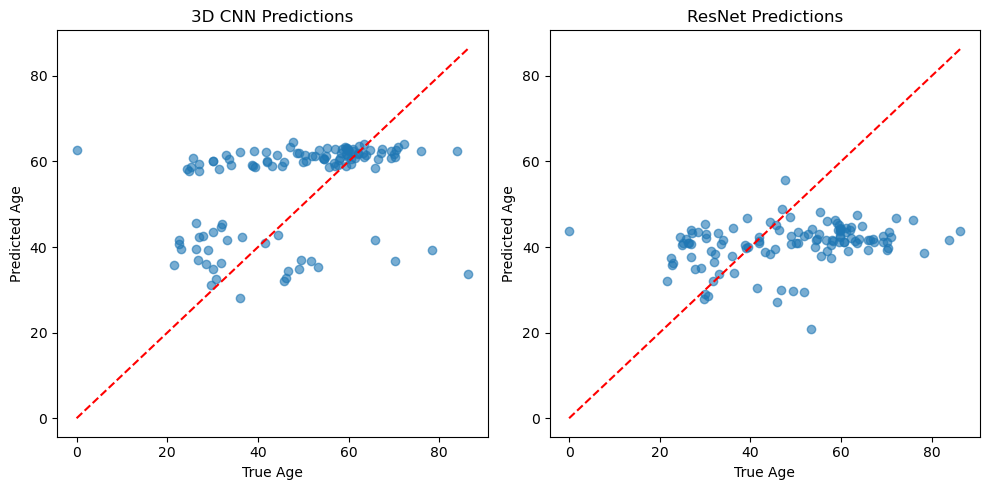

Models, predictions, and graphs saved.


In [79]:
# Plot Results
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, cnn_preds, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('3D CNN Predictions')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')

plt.subplot(1, 2, 2)
plt.scatter(y_test, resnet_preds, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('ResNet Predictions')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')

plt.tight_layout()
plt.savefig('prediction_graphs.png')
plt.show()

print("Models, predictions, and graphs saved.")

In [81]:
with open("D:/mp/brain age/cnn_model.pkl", "wb") as f:
    pickle.dump(cnn_model, f)

In [83]:
with open("D:/mp/brain age/model_resnet.pkl", "wb") as f:
    pickle.dump(resnet_model, f)
